<a href="https://colab.research.google.com/github/sulimankhan587/CNN_Car_Detection/blob/main/CNN_Car_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Dependencies

In [ ]:
# Data Operations
import numpy as np
import pandas as pd
import os

# Visualization/Image Processing
import cv2
import matplotlib.pyplot as plt

# Machine Learning
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, BatchNormalization, Flatten, MaxPool2D, Dense

from sklearn.model_selection import train_test_split

import glob
import os



# Data Observations
- There ara multiple cars in some images with multiple boundary boxes in them
- We must build a model regarding these boxes all for one image. Otherwise accuracy will get much lower
- Grouping the images with boxes together is a must

In [ ]:
test_images_paths=glob.glob("/content/drive/MyDrive/dataset/data/testing_images/*.jpg")
train_images_paths=glob.glob("/content/drive/MyDrive/dataset/data/training_images/*.jpg")
print(f"Train images data size is {len(train_images_paths)} besides test images data size is {len(test_images_paths)}")

Train images data size is 822 besides test images data size is 175


# Preprocessing and Data Loading

In [ ]:
train= pd.read_csv("/content/drive/MyDrive/dataset/data/train_solution_bounding_boxes (1).csv")
train= train.groupby("image")[["xmin","ymin","xmax","ymax"]].apply(lambda x:x.values.astype(int).flatten().tolist()).reset_index()
train.rename(columns={0:"coordinates"},inplace=True)
max_length=train["coordinates"].apply(len).max()
train["coordinates"]=train["coordinates"].aggregate(lambda x:x+[0]*(max_length-len(x))) #equalize the coordinates with empty boxes for no needed ones

In [ ]:
len(train)

355

In [ ]:
# Checking the length of coordinates
train["coordinates"].apply(len).min() # So far all we have done is nice.

28

# Displaying Some Images

In [ ]:
# We define a function for using either now or later
def display_image(img,bbox_coords=[],pred_coords=[],normalize=False):
    """
    Function: Receives an image and display it with boundary box
    parameters:
        bbox_coords : If True,shows boundary box(es) of the specific image(s) with green color line
        pred_coords : If True,shows the predicted boundary boxes with red color line
        normalize   : Rescales the channels if normalize is True
    """

    if normalize:
        img=img/255

    while len(pred_coords)>0:
        xmin, ymin, xmax, ymax=pred_coords[:4]
        pred_coords=pred_coords[4:]
        cv2.rectangle(img,(int(xmin), int(ymin)), (int(xmax), int(ymax)),(255,0,0),thickness=2)  #Red channel

    while len(bbox_coords)>0:
        xmin, ymin, xmax, ymax=bbox_coords[:4]
        bbox_coords=bbox_coords[4:]
        cv2.rectangle(img,(int(xmin), int(ymin)), (int(xmax), int(ymax)),(0,255,0),thickness=2)  # Green channel

    plt.imshow(img)
    plt.axis("off")


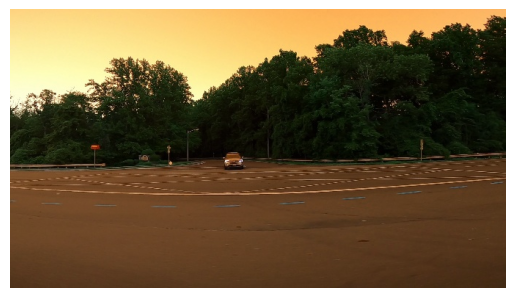

In [ ]:
# Display an image with boxes
train["image_path"]="/content/drive/MyDrive/dataset/data/training_images/"+train["image"]
display_image(cv2.imread(train["image_path"][0]))

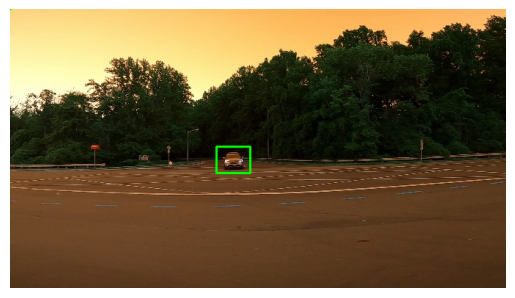

In [ ]:
# Now let's see the same image with boxes
display_image(cv2.imread(train["image_path"][0]),bbox_coords=train["coordinates"][0])

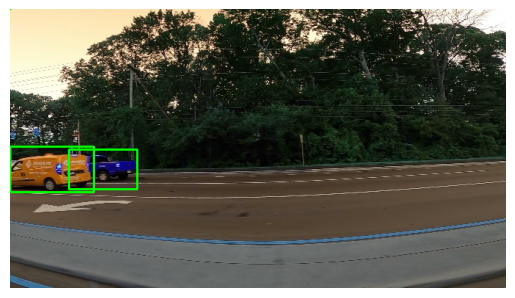

In [ ]:
# The one  within multiple cars and boxes
display_image(cv2.imread(train["image_path"][48]),bbox_coords=train["coordinates"][48])

# Create A Generator For Our Model
We will use data_generator in our model,by this the model has got X values("image") and y values("coordinates). The key values are critical point. Keras expects in its layers that we will determine,as keras needs them to locate the correct input/output.

In [ ]:
#Here we put python expression yield insted of return because in generator it is used yield for many reasons.
# To learn about generators in python please visite "https://www.programiz.com/python-programming/generator"
def data_generator(df=train,batch_size=16):
    """
        Function: returns images in batch_size with the bbox coordinates they have
    """
    while True:   # if you add a while loop,the generator will give product once not anymore
        images = np.zeros((batch_size, 380, 676, 3))  #(380,676,3) is all images' size
        bbox_coords = np.zeros((batch_size, max_length))

        for i in range(batch_size):
            rand_index = np.random.randint(0, train.shape[0])
            row = df.loc[rand_index, :]
            images[i] = cv2.imread(row.image_path) / 255.
            bbox_coords[i] = np.array(row.coordinates)

        yield {'image': images}, {'coordinates': bbox_coords}

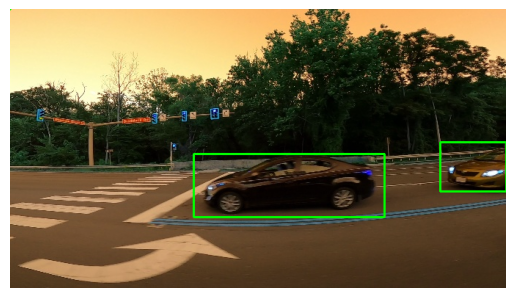

In [ ]:
# Test our generator
img,label=next(data_generator(batch_size=1))
img=img["image"][0]
bbox_coords = label['coordinates'][0]
display_image(img,bbox_coords=bbox_coords)

# Model Architecture
Notice that the dictionary keys in the generator correspond to the names of the input and output layers.

In [ ]:
shape=(380, 676, 3)
inputs=Input(shape=shape,name="image")   # image data come from data_generator
x=inputs
n_filters=0
for i in range(5):    #  Convolutional Blocks
    n_filters=2**(i+2)
    x=Conv2D(n_filters,3,activation="relu", padding='same')(x)
    x=BatchNormalization()(x)
    x=MaxPool2D(2, padding='same')(x)

x=Flatten()(x)
x=Dense(256,"relu")(x)
x=Dense(32,"relu")(x)
output = Dense(28, activation='relu',name='coordinates')(x)   # coordinates data come from data_generator

model=tf.keras.models.Model(inputs,output)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 380, 676, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 380, 676, 4)       112       
                                                                 
 batch_normalization (Batch  (None, 380, 676, 4)       16        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 190, 338, 4)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 190, 338, 8)       296       
                                                                 
 batch_normalization_1 (Bat  (None, 190, 338, 8)       32    

In [ ]:
model.compile(loss="mse",optimizer="adam",metrics="accuracy")

Keras enables us to create many customized callbacks like used on_epoch_ends.. Now we define a callback to test the model after every epoch ends.

In [ ]:
# Some functions to test the model. These will be called every epoch to display the current performance of the model
def test(model):
    # Show three images for testing
    plt.figure(figsize=(15,7))
    for i in range(3):

        plt.subplot(1, 3, i + 1)
        example,label=next(data_generator(batch_size=1))#bbox_coords=[],pred_coords=
        X = example['image']
        y = label['coordinates']

        img=X[0]
        gt_coords=y[0]
        pred_bbox = model.predict(X)[0]
        display_image(img,bbox_coords=gt_coords,pred_coords=pred_bbox)
    plt.show()

class TestImages(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs=None):
        test(self.model)

1/1 [==============================] - 1s 833ms/step


1/1 [==============================] - 0s 146ms/step


1/1 [==============================] - 0s 160ms/step


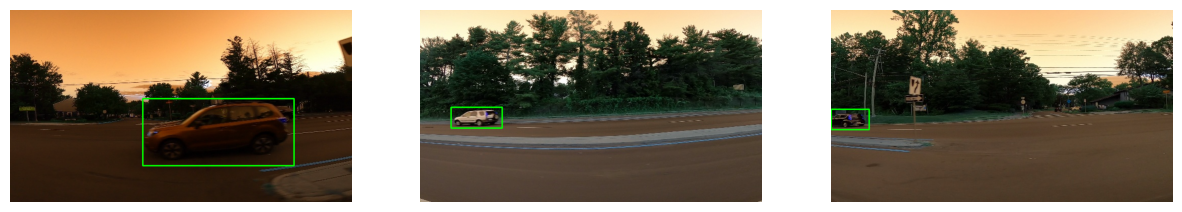

In [ ]:
# Testing everything before process is not a wasting time. Test it now
test(model)

Epoch 1/15
1/1 [==============================] - 0s 21ms/step


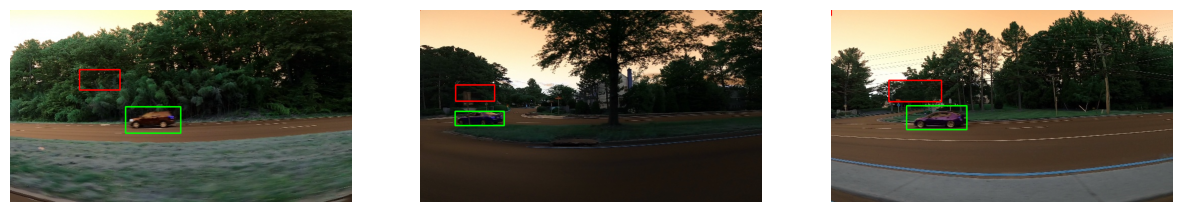

500/500 [==============================] - 147s 280ms/step - loss: 5408.4570 - accuracy: 0.7541
Epoch 2/15
1/1 [==============================] - 0s 23ms/step


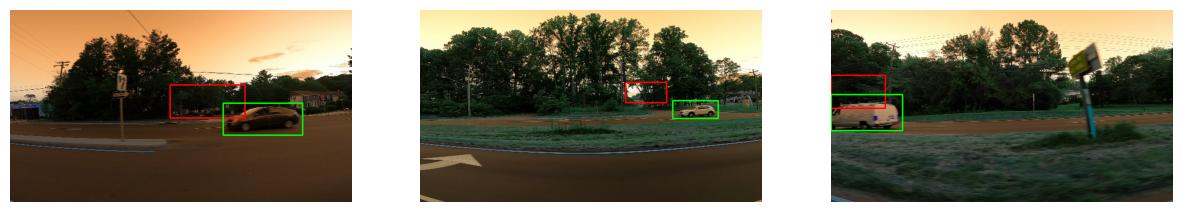

500/500 [==============================] - 139s 279ms/step - loss: 2354.7710 - accuracy: 0.9599
Epoch 3/15
1/1 [==============================] - 0s 25ms/step


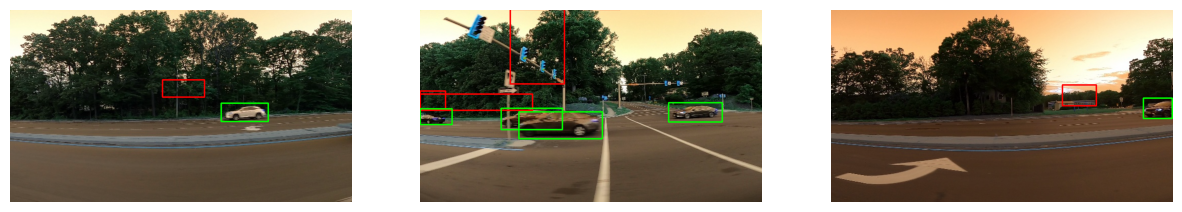

500/500 [==============================] - 135s 271ms/step - loss: 2298.0330 - accuracy: 0.9682
Epoch 4/15
1/1 [==============================] - 0s 24ms/step


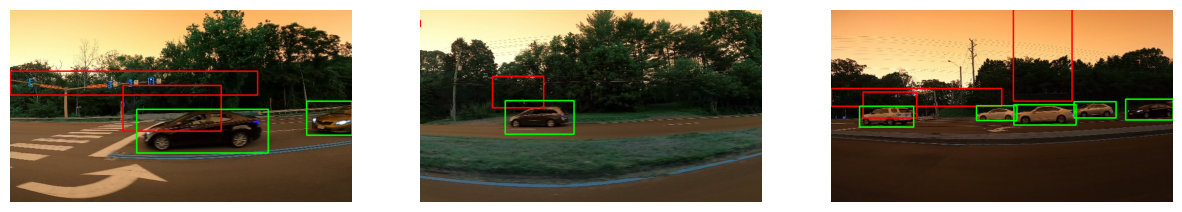

500/500 [==============================] - 138s 277ms/step - loss: 2176.4207 - accuracy: 0.9690
Epoch 5/15
1/1 [==============================] - 0s 23ms/step


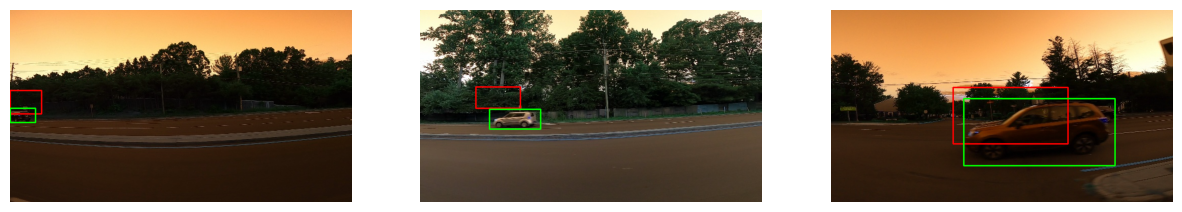

500/500 [==============================] - 141s 282ms/step - loss: 2270.3401 - accuracy: 0.9712
Epoch 6/15
1/1 [==============================] - 0s 24ms/step


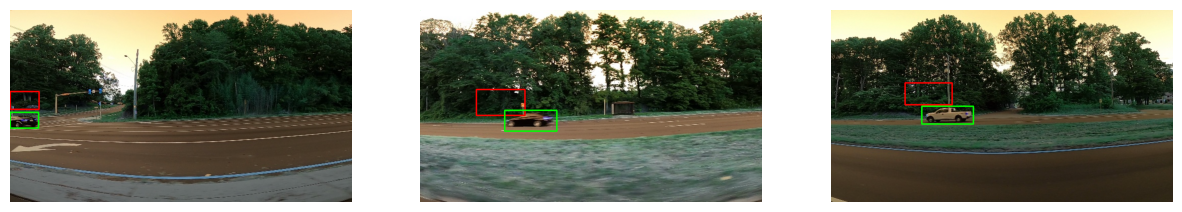

500/500 [==============================] - 145s 290ms/step - loss: 2256.1489 - accuracy: 0.9756
Epoch 7/15
1/1 [==============================] - 0s 25ms/step


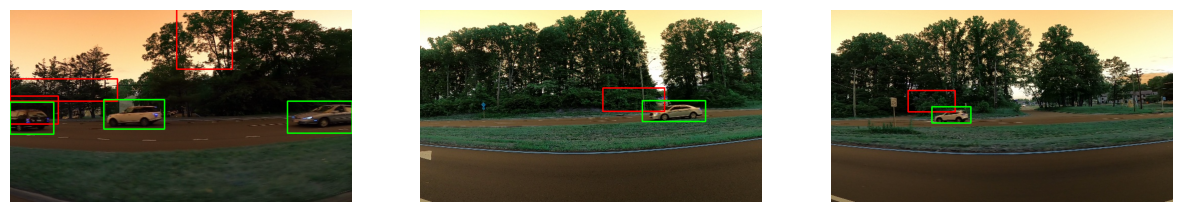

500/500 [==============================] - 145s 290ms/step - loss: 2307.1790 - accuracy: 0.9731
Epoch 8/15
1/1 [==============================] - 0s 23ms/step


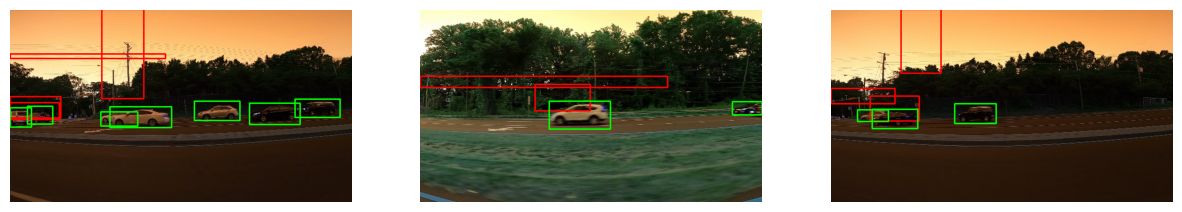

500/500 [==============================] - 143s 286ms/step - loss: 2256.7800 - accuracy: 0.9728
Epoch 9/15
1/1 [==============================] - 0s 21ms/step


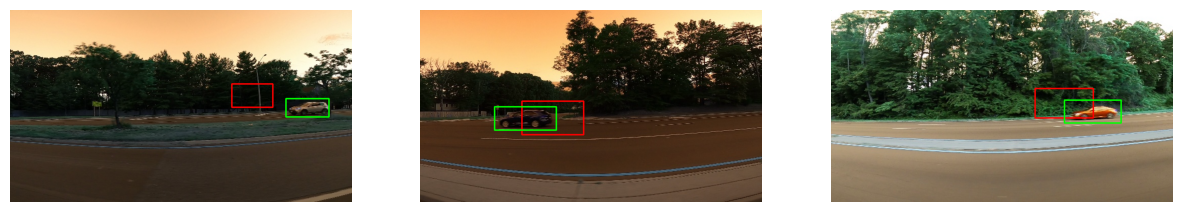

500/500 [==============================] - 140s 281ms/step - loss: 2207.4446 - accuracy: 0.9769
Epoch 10/15
1/1 [==============================] - 0s 21ms/step


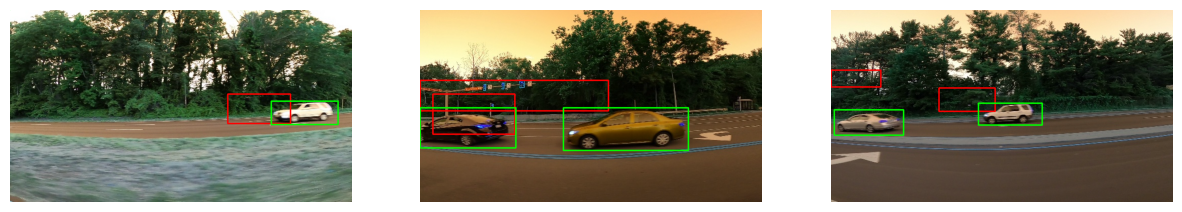

500/500 [==============================] - 141s 282ms/step - loss: 2180.8713 - accuracy: 0.9790
Epoch 11/15
1/1 [==============================] - 0s 22ms/step


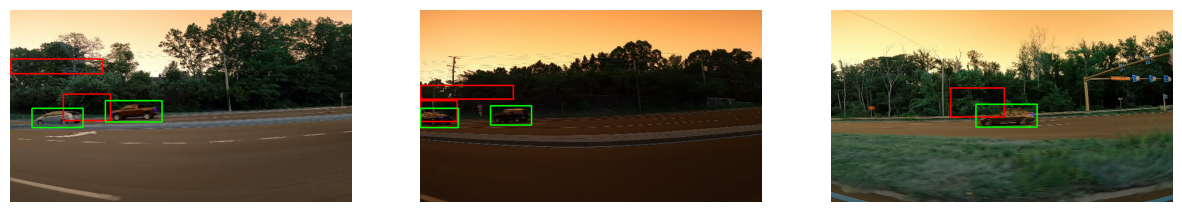

500/500 [==============================] - 140s 281ms/step - loss: 2286.7410 - accuracy: 0.9746
Epoch 12/15
1/1 [==============================] - 0s 22ms/step


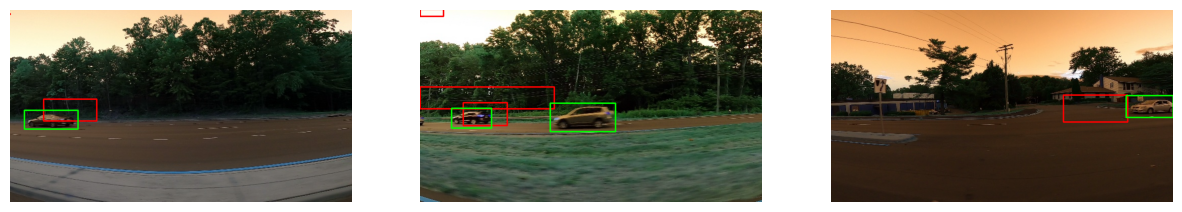

500/500 [==============================] - 141s 282ms/step - loss: 2172.2388 - accuracy: 0.9781
Epoch 13/15
1/1 [==============================] - 0s 22ms/step


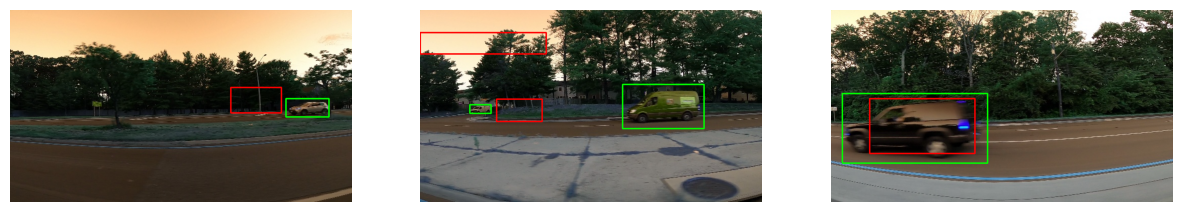

500/500 [==============================] - 137s 275ms/step - loss: 2232.4749 - accuracy: 0.9787
Epoch 14/15
1/1 [==============================] - 0s 31ms/step


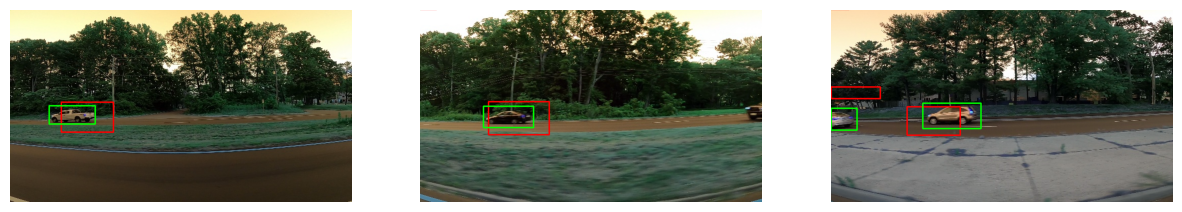

500/500 [==============================] - 137s 275ms/step - loss: 2168.8257 - accuracy: 0.9844
Epoch 15/15
1/1 [==============================] - 0s 20ms/step


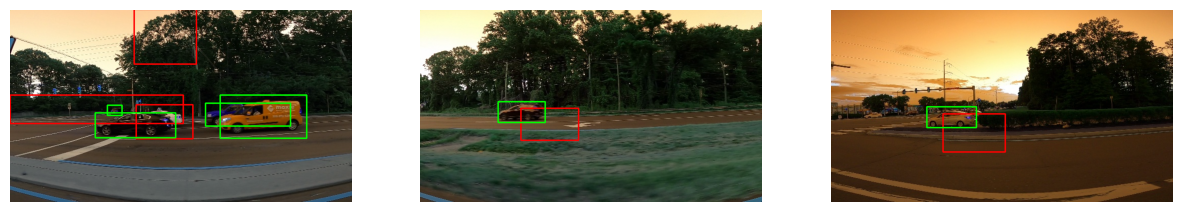

500/500 [==============================] - 136s 272ms/step - loss: 2178.0813 - accuracy: 0.9776


In [ ]:
# train the model
with tf.device('/GPU:0'):
    _= model.fit(data_generator(), epochs=15, steps_per_epoch=500, callbacks=[TestImages()])

As the data is not so large and computing time gets longer, we will leave this here. Actually the results are good anyway.